<a href="https://colab.research.google.com/github/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/FULL_CREATION_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Creation.

This Notebook contains the code to import six datasets containing either disinformation, misinformation fake news or propaganda, true news articles or other non-false texts, or a combination of these.  

While this study has a focus on politically motivated disinformation (i.e the bulk of texts are deliberately misleading or false statement with certain political goals), texts that are false or misleading without deliberate intent are also included to more closely mimic the the variety encoutered on e.g. social media platforms in real life).  
<br>

<b>Dataset compilation (section 1 - 3):</b> 

Compiling different datasets as done in this study requires carefull formatting to make sure all sets can be combined as one. Sections 1 - 3 read in to the six datasets from csv, create a consistent format, drop duplicates and combine them into a single consistent +73k dataset. 
<br><br>


<b>Minimal cleaning (section 4):</b>  
In order to keep our texts as close to the raw data as possible, we will limit ourselves to only manipulating substrings that can be directly used by the model to differentiate disinformation from true articles due to a lack in representivity in true/false sets (e.g. the "reuters" prefix that is common in true labeled articles scraped from reuters.). 
<br><br>
<b>EDA  (section 7):</b>  
While not the focus of this study, I have added a quick simple EDA by creating the most obvious but practically interesting linguistic features to get a rough understanding of linguistic/stylistic differences between disinformation and regular articles (e.g. average sentence lengths, number of hyperlinks, hashtag usage, stopword counts etc).
<br><br>
<b>Prepping for translation  (section 8-10):</b>  
This study needed a 30% test set (referred to as testN0) and a backtranslated version of that exact testset (testN1) and another backtranslated version of that one (now called testN2) until 'testN3'. This would allow me to compare diffent architectures on their AUC decay as noise increases due the the backtranslation inaccuracies.
Secondly, text were xut short to 2800 characters as google translate would sporadically block backtranslation of texts around 3000 characters and above (while messaging that 3900 characters was the limit).
<br><br>
<b>Three levels of Backtranslation using gooogle translate API (section 11):</b>  
Google translate was chosen for this, as this is the machine translation service worldwide, especially for relatively short texts that are typical on social media. Given the size of our dataset a batching system (a total of 50 splits) had to created in order to prevent timeouts by google translate.  
The three test sets to be used later are exported to csv's in section 12.  
<br>
<b>Induced noise approximated as Lexical Distance (section 13):</b>  
In order to have a universal, objective proxy for the noise created through the different levels of backtranslation the Jaro Winkler Distance (normalized) was taken and saved to csv.

# 0. Imports and GDrive connection ('mounting')

In [ ]:
import os
import pandas as pd
import numpy as np
import re

In [ ]:
!pip install googletrans==3.1.0a0
# version hardcoded because of an error in the latest version..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 2.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=e4ae6252c10a4ed1dd6943ef66ca1bf6b99b52f9f0982652c9bc0fed001cc103
  Stored in directory: /root/.cache/pip/wheels/dd/59/af/8d6c96a719763990f1c548e36b17d9efdfb767f42f7ff39f53
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Reading in the datasets (true & false)

In [ ]:
#datasets with political disinfo, fake news and regular news
path1 = '/content/drive/MyDrive/MYDATA/UVIC-ISOT/Fake.csv' #FAKE  University of Victoria #ISOT Ahmed H, Traore I, Saad S.  UVIC-ISOT
path2 = '/content/drive/MyDrive/MYDATA/21k_Chendra/fake_train.csv' #FAKE&TRUE  #20k dataset without further description
path3 = '/content/drive/MyDrive/MYDATA/6k_Jillani/fake_or_real_news.csv'#FAKE&TRUE  #same as RALUCACHITIC set, 6060 balanced.
path4 = '/content/drive/MyDrive/MYDATA/EUvsDisinfo.eu/data/data.csv' #FAKE  #EUvsDisinfo dataset (scraped) 2016-2020 6k
path5 = '/content/drive/MyDrive/MYDATA/UVIC-ISOT/True.csv' #TRUE. #ISOT Ahmed H, Traore I, Saad S. dataset of ±21k UVIC-ISOT

#--- extra: chinese covid (dis)info ('CHECKED-project):
path6 = '/content/drive/MyDrive/MYDATA/MonkeyPoxMisinfo/monkeypox.csv' #mixed twitter, monkeypox (factchecked)


In [ ]:
#the fake/true nomenclature here describes the set to be, not the current status (i.e. fake and true mixed sets are named both true and fake at this stage)

#fake:
df_fake1 = pd.read_csv(path1)
df_fake2 = pd.read_csv(path4)
#true:
df_true1 = pd.read_csv(path5)
#mixed:
df_mixed1 = pd.read_csv(path2)
df_mixed2 = pd.read_csv(path3)
df_mixed3 = pd.read_csv(path6)
#df_mixed_copies (needed for formatting function for now)
df_mixed1B = pd.read_csv(path2)
df_mixed2B = pd.read_csv(path3)
df_mixed3B = pd.read_csv(path6)

In [ ]:
print('fake1 shape: {}'.format(df_fake1.shape)) # 23.481, 4
print('fake2 shape: {}'.format(df_fake2.shape)) # 7.369, 36

print('true1 shape: {}'.format(df_true1.shape)) # 21.417, 4

print('mixed1 shape: {}'.format(df_mixed1.shape)) # 20.800,5
print('mixed2 shape: {}'.format(df_mixed2.shape)) # 6.335, 4
print('mixed3 shape: {}'.format(df_mixed3.shape)) # 5.787, 19

fake1 shape: (23481, 4)
fake2 shape: (7369, 37)
true1 shape: (21417, 4)
mixed1 shape: (20800, 5)
mixed2 shape: (6335, 4)
mixed3 shape: (5787, 19)


In [ ]:
#one manual tweak for dataset 4 needed for the function to work on all 4
df_fake2.drop('text', axis=1, inplace = True)
df_fake2.rename(columns = {'claim_reviewed':'text'}, inplace = True)
df_mixed3.rename(columns = {'binary_class':'label'}, inplace = True)
df_mixed3B.rename(columns = {'binary_class':'label'}, inplace = True)

In [ ]:
#df_fake1.head() 
#text includes twitter @mentions, 'photo by..'  etc
#especially 'photo by..' needs to be removed

# 2. One format for all dataset (in a single function)




Let's start without reading the files (so no loop needed yet) and just doing the removal of empties and deduplication. TO be exact:


1.   drop rows that have labels for non corresponding truth value (so that we have truth and false seperates prior to joining)
2.   drop each column that is not the text column
3.   drop all empties (including 'fake empties')
4.   drop duplicates
5.   add label column
6.   return the 'new' dataset.





In [ ]:
def removeEmpties_Deduplicate(x,tf_num, tf_term):
  ''' trying a function to do the repetitive work
  purpose:
  This function is to deduplicate as well as separate true from false in the labeled datasets that are our source data.
  This allows me to use a single function on the 7 difference datasources used, and have deduplicated and compatible dataframes as output
  seperated for true and false values. To be combined to the single overal dataset after further cleaning.
  input:
  x : the dataframe to work with
  tf_nm : truth/false numerical, 0 for the 'true' labels, 1 for the disinfo labels.
  tf_term : truth/false in terms, 'TRUE' for the 'true' labels, 'FAKE' for the disinfo labels.
  output:
  dataframe x
  '''
  #remove the unwanted rows (true or fake) depending on set (based on label value == 0 or 1 under tf_num variable)
  #doing the same with those were true or false is code in text ('REAL' or 'FAKE', with tf_term)
  try:
    x.drop(x.index[x['label'] == tf_num], inplace=True)
    x.drop(x.index[x['label'] == tf_term], inplace=True)
  
    
    #x.rename(columns = {'claim_reviewed':'text'}, inplace = True). #not possible in combination with try except (and double 'text' column names..)
  except:
    print('(step to be skipped as the change is not needed for this dataset)')
  finally:
    #remove unneeded colums (so as filter..)
    columnkeeper = ['text']
    x = x.drop(x.columns.difference(columnkeeper), axis=1)
    #replace space empties with recognized empties, then drop all empties
    x['text'].replace(' ', np.nan, inplace=True)
    x.dropna(
      axis=0,
      how='any',
      subset=None,
      inplace=True)
    #remove duplicates with pandas function
    x = x.drop_duplicates(subset=["text"], keep='first')
    #add column with true of false statement (1- value to reverse code..)
    x['label'] = (1-tf_num)
    print(' > This dataset has shape:{}'.format(x.shape))
    return x 

## Applying the formatting function on all sets:




In [ ]:
DatasetList_FAKEandMIXED = [df_fake1, df_fake2, df_mixed1, df_mixed2, df_mixed3]
DatasetList_TRUEandMIXED = [df_true1, df_mixed1B, df_mixed2B, df_mixed3B]
#one list is also possible without any changes needed.. but not this is better for readability

List_DataSets = []
#List_TRUE =[]

#disinformation sets:
print('--- Running the prep function on the disinfo + mixed sets:')
for i in DatasetList_FAKEandMIXED:
   List_DataSets.append(removeEmpties_Deduplicate(i, 0, 'REAL' ))
   #DROPPING rows with value 0 or 'real', to retain only disinfo.

#true news/info sets:
print('--- Running the prep function on the true + mixed sets:')
for i in DatasetList_TRUEandMIXED:
  List_DataSets.append(removeEmpties_Deduplicate(i, 1, 'FAKE' ))
   #DROPPING rows with value 1 or 'fake', to retain only true.


#QUESTION: check if there arent rows that are not dropped that should be dropped in the above..
print('--- cleaning, now running through shape of all list objects (df) ---')  

"""
#use this to check all shapes:
for i in List_DataSets:
  print('dataset has shape: {}'.format(i.shape))
"""

--- Running the prep function on the disinfo + mixed sets:
(step to be skipped as the change is not needed for this dataset)
 > This dataset has shape:(17454, 2)
(step to be skipped as the change is not needed for this dataset)
 > This dataset has shape:(6043, 2)
 > This dataset has shape:(9998, 2)
 > This dataset has shape:(3070, 2)
 > This dataset has shape:(1035, 2)
--- Running the prep function on the true + mixed sets:
(step to be skipped as the change is not needed for this dataset)
 > This dataset has shape:(21191, 2)
 > This dataset has shape:(10387, 2)
 > This dataset has shape:(2989, 2)
 > This dataset has shape:(4231, 2)
--- cleaning, now running through shape of all list objects (df) ---


"\n#use this to check all shapes:\nfor i in List_DataSets:\n  print('dataset has shape: {}'.format(i.shape))\n"

In [ ]:
#List_DataSets[0] #= 17454 rows × 2 columns  -fake1
#List_DataSets[1] #= 6043 rows × 2 columns   -fake2
#List_DataSets[2] #= 9998 rows × 2 columns   -mixed1 <- disinfo
#List_DataSets[3] #= 3070 rows × 2 columns   -mixed2 <- disinfo
#List_DataSets[4] #= 1035 rows × 2 columns   -mixed3 <- disinfo
#List_DataSets[5] #= 21191 rows × 2 columns  -true1
#List_DataSets[6] #= 10387 rows × 2 columns  -mixed1B <- true
#List_DataSets[7] #= 2989 rows × 2 columns   -mixed2B <- true           
#List_DataSets[8] #= 4231 rows × 2 columns    -mixed3B <- true                  
#List_DataSets[9] #= out of range                     

# 3. Combine all dataframes into one 'fake' and 'true' labeled dataframe.

*   combine ('union' in SQL terms, 'concat' in python)
*   trim trailing and starting whitespace (just to be safe)
*   drop duplicates (as after union new duplicates are possible)




In [ ]:
#creating a 'union' of all the dataframes (concat)
df_unionedlist = pd.concat(List_DataSets, ignore_index=True)

#trimming before checking for duplicates (this helps us find 2486 dupes instead of 2473)
df_unionedlist['text'] = df_unionedlist['text'].str.strip()

In [ ]:
df_unionedlist.shape # (71132, 2)

(76398, 2)

In [ ]:
#checking for empties in the text column.
df_unionedlist['text'].isna().sum() #after function, all are zero :)
#repeat this after removing suffixes and prefixes!

0

In [ ]:
dupes = df_unionedlist[df_unionedlist.duplicated(subset = 'text', keep = 'first')]
dupes.shape #2487 duplicates
#having done the trimming before checking for duplicates helped us find 2487 dupes instead of 2475

(2487, 2)

In [ ]:
#dropping the dupes found above (if correctly done, there should be 71132-2487= 68645 unique rows left)
df_unionedlist.drop_duplicates(subset='text', keep='first', inplace=True) # ignore_index=False)
df_unionedlist.shape

(73911, 2)

# 4. Removing the source prefixes and other suffixes

(e.g. 'photo by... Feature.. and 'WASHINGTON (Reuters)..)


In [ ]:
#make a working copy of the df before making changes to the data
df_full = df_unionedlist

In [ ]:
#suffixes = ['Photo by', 'Featured image']
#prefixes = washington//.

In [ ]:
#removing all the suffixes by deleting everything right of ' Photo by.. '
#df_unionof4sets['text'] = df_unionof4sets['text'].str.split('Photo by'|'Featured image').str[0]
import re
df_full['text'] = df_full['text'].apply(lambda x: re.split(r'Photo by|Featured image', x)[0])

In [ ]:
#df_unionof3sets['text'] = df_unionof3sets['text'].apply(lambda x: re.split(r'WASHINGTON \(Reuters\) - |WEST PALM BEACH, Fla \(Reuters\) - ', x)[-1])
df_full['text'] = df_full['text'].apply(lambda x: re.split(r' - |\(CNN\)', x)[-1])

In [ ]:
#this can be done better (like with a list od city names followed by a ' - '.. instead of only washsington or somehting)
#another option woould be to delete everything before the - IF the - is within the first 20 chars of the doc..


#df_full.head(10)
#df_full.tail(10)
df_full.sample(10)

,text,label
32760,Trump convocará mañana mismo las elecciones a ...,1
25592,"Posted on October 31, 2016 by Dr. Eowyn | 2 Co...",1
9067,According to Fox News A federal grand jury on...,1
56199,An Egyptian court sentenced top Muslim Brother...,0
20866,The story about Russia's involvement in the DN...,1
26770,"A 23 kiloton tower shot called BADGER, fired o...",1
24543,Email \nIf you want to see the full depths of ...,1
59560,"The way Donald J. Trump tells it, his first so...",0
30019,Natural Blaze \nBrandon Turbeville made a fasc...,1
63679,"OAKLAND, Calif. — The beautiful millionaire...",0


In [ ]:
#Looking at twitter mentions/handles:
#df_full['text'].str.findall(r'[＠@]([^][\s#<>|{}]+)')
#df_full['mention'] = df_full['text'].str.findall(r'[＠@]([^][\s#<>|{}]+)')    #creating a column filled with the mention

#Looking at hashtags:
#df_full.text.str.extractall(r'(\#\w+)')[0].value_counts()

#I need to check here whether twitter data is only 'fake' or also true (if not balanced, all hashtags and handles need to be removed)

# 5. Exporting to csv
- name: FullMixedDataset1.csv
- Location: MyDrive/MYDATA

In [ ]:
df_full.to_csv(r'/content/drive/MyDrive/MYDATA/FullMixedDataset1.csv')

# 6. Importing stored csv + balance check

- after having saved the raw file as csv, we will read it in anew.
This helps us in troubleshooting later, and makes it easier to make changes later on without breaking the code.
- check (again) for empties + remove empties
- check balance of dataset (count 0's and 1's)

In [ ]:
step2path1 = '/content/drive/MyDrive/MYDATA/FullMixedDataset1.csv' 
df_full1 = pd.read_csv(step2path1, index_col=[0])

In [ ]:
#repeat the check for empties, as here suffixes and prefixes have been deleted..
df_full1['text'].isna().sum()

14

In [ ]:
df_full1.dropna(
      axis=0,
      how='any',
      subset=None,
      inplace=True)

In [ ]:
#calculate balance of dataset 
news = df_full1['label'].value_counts()[0]
disinfo = df_full1['label'].value_counts()[1]

disinfoPercent = ((disinfo/(disinfo+news))*100)
'disinfo precentage of total dataset is {number:.{digits}f}%'.format(number=disinfoPercent, digits=2)

'disinfo precentage of total dataset is 47.50%'

In [ ]:
print('there are {} rows of real news'.format(df_full1['label'].value_counts()[0]))
print('and {} rows of disinfo'.format(df_full1['label'].value_counts()[1]))

there are 38797 rows of real news
and 35100 rows of disinfo


# 7. EDA (preliminary) DO NOT RUN!

ignore this section for now
** Do Not Run! **


## Features egineering
- ToDo: use percentages instead of raw *counts*

In [ ]:
#make copy of dataset
df_full_EDA = df_full2


# word_count
df_full_EDA['word_count'] = df_full_EDA['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_full_EDA['unique_word_count'] = df_full_EDA['text'].apply(lambda x: len(set(str(x).split())))

In [ ]:
from wordcloud import STOPWORDS
df_full_EDA['stop_word_count'] = df_full_EDA['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [ ]:
# punctuation_count.  # not working, string.punctuation is giving problems
#df_full_EDA['punctuation_count'] = df_full_EDA['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [ ]:
# mean_word_length
df_full_EDA['mean_word_length'] = df_full_EDA['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
# url_count
df_full_EDA['url_count'] = df_full_EDA['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [ ]:
# hashtag_count
df_full_EDA['hashtag_count'] = df_full_EDA['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [ ]:
# mention_count
df_full_EDA['mention_count'] = df_full_EDA['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

## Plotting the created features (viz) + conclusion about dataset
- ToDo: see 'feature egineering'
- TODo: all vizuals in a grid

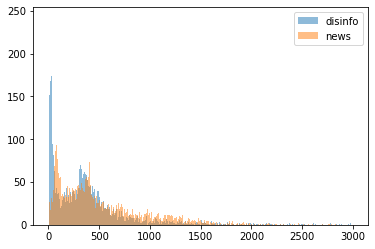

In [ ]:
import matplotlib.pyplot as pyplot

x=df_full_EDA.loc[df_full_EDA['label']==1, 'word_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'word_count']

bins=list(range(3000))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

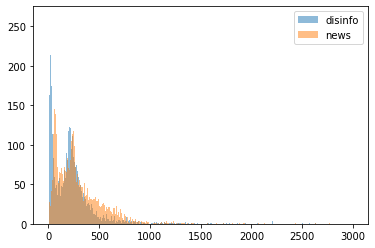

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'unique_word_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'unique_word_count']

#bins=list(range(3000))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

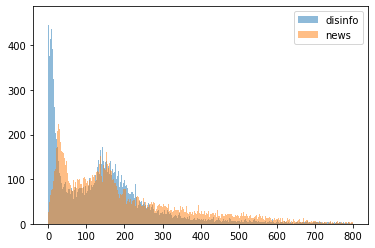

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'stop_word_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'stop_word_count']

bins=list(range(800))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

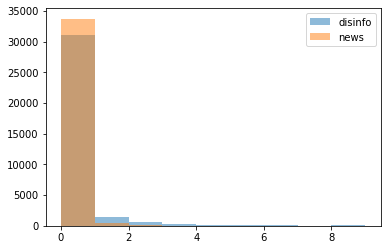

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'hashtag_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'hashtag_count']

bins=list(range(10))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

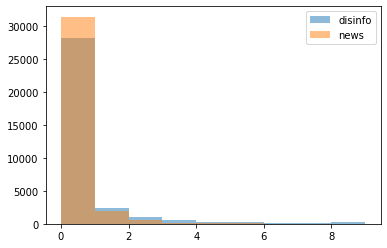

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'mention_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'mention_count']

bins=list(range(10))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

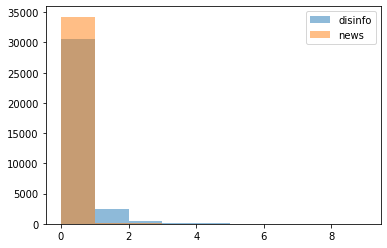

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'url_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'url_count']

bins=list(range(10))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

Preliminary (eyeballed) conclusions:
- disinfo texts are mote likely to have @mentions, urls and hasthtags.
- extremely short texts are more likely to be disinfo
- These conclusions are more likely to be a dataset problem more than a real inference about news vs disinfo..

ToDo:
- see above (bulletpoint 3)
- for e.g. stopword count, make it stopwordcount as ratio of total word count. etc
- put in grid
- get data that is not 'news', but non disinfo texts not written by professional journalists.

# 8. Texts that are 'too short' and 'too long'..

In [ ]:
df_full1['text_length'] = df_full1.text.apply(len)

In [ ]:
#are there texts with fewer than 100 characters?
column = df_full1['text_length']
tooshort = 30
toolong = 2800 #max char length for google translate is 3900.. (this is a bug in GT, while it is possible that RU is lengthier than english, when putting in 3000 chars russian, it will give '>3900 warning'
count_tooshort = column[column < tooshort].count()
count_toolong = column[column > toolong].count()
print(f'there are {count_tooshort} rows with texts that are too short (i.e. <{tooshort})')
print(f'there are {count_toolong} rows with texts that are too long (i.e. >{toolong})')

there are 567 rows with texts that are too short (i.e. <30)
there are 23703 rows with texts that are too long (i.e. >2800)


In [ ]:
df_full1.shape # (68631, 3). NOW: -> (73897, 3)

(73897, 3)

In [ ]:
#drop all rows that have fewer then 30 characters (i.e. 'keep those larger than or equal to 30')
df_full2 = df_full1.loc[df_full1["text_length"] >= tooshort]
#df_full3.shape # -> = 68309, 3

#we can do the same for rows that are too long, however it will we better to cut them off after e.g. 5000 chars and leave them in the dataset.

In [ ]:
# keeping only the first 3500 chars of each row in text column
df_full2['text'] = df_full2['text'].str.slice(0,toolong)

<ipython-input-33-af2d8b63e502>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full2['text'] = df_full2['text'].str.slice(0,toolong)


In [ ]:
#adding a column with new length counts to check whether indeed cutoffs at defined max length (i.e. 'toolong')
df_full2['text_len_trunc'] = df_full2.text.apply(len)

<ipython-input-34-233dee3968c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full2['text_len_trunc'] = df_full2.text.apply(len)


In [ ]:
df_full2.sample(5)

,text,label,text_length,text_len_trunc
17550,The association agreement between Ukraine and ...,1,202,202
22094,Almost half of the Austrian electorate would p...,1,67,67
54329,A proposal to convene a congress of all Syria ...,0,505,505
684,Before Donald Trump stepped foot in the White ...,1,1873,1873
62816,ABC’s decision to cancel its popular comedy ...,0,6833,2800


  ##    9b. SQL section (optional)

In [ ]:
# SQL block
!pip install -U pandasql
from pandasql import sqldf

# purpose:
# To find out how the extreme short (that are to be removed) and extreme long texts (that are to be cut off) are distributed between
# news and disinfo SQL is used to count them. (this can also be done in pandas but my coding is not strong enough).

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=36d378515d55bfb86350fb7448b2a8d6c9d79a2264f8af1f0dab492b1b628016
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


In [ ]:
# Query definition
query = """ SELECT count(*) 
            FROM df_full2
            WHERE (text_length < 20)
            GROUP BY label  
        """

# Query execution
tooshort_distribution = sqldf(query, globals())
tooshort_distribution

,count(*)


In [ ]:
# Query definition
query = """ SELECT count(*) 
            FROM df_full2
            WHERE (text_length > 2000)
            GROUP BY label  
        """

# Query execution
toolong_distribution = sqldf(query, globals())
toolong_distribution

,count(*)
0,20385
1,15987


# 9. Splitting into train and test

In [ ]:
X = df_full2['text']
y = df_full2['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state=42)   #0.2 is normal but is a bit too heavy to work with in translation..

In [ ]:
#X_train.shape # (67625,)
X_test.shape   # (684,)

(21999,)

In [ ]:
#trainset will be used to train each embedding-model architecture
trainset = pd.concat([X_train, y_train],axis=1)

#testset will be used to create testN1, testN2 and testN3, which will be used for comparing scores across models
#where N1 will stand for 'noise level 1' (induced by amchine translation), N2 for noise level 2 etc.
testset = pd.concat([X_test, y_test],axis=1)

# 10. Exporting both train and test sets.
- testset is to be used for translation to create several different test sets.
- train is to be used for embeddings and model training.

In [ ]:
testset.to_csv('/content/drive/MyDrive/MYDATA/df_full2_TEST30split.csv', index=False)

In [ ]:
trainset.to_csv('/content/drive/MyDrive/MYDATA/df_full2_TRAIN30split.csv', index=False)

# 11 Testset translation  (Version 3, dict + split method..)
create testset text_N1, text_N2 and text_N3 using backtranslation
WARNING! RUNNING THIS BLOCK TAKES A LONG TIME!

In [ ]:
pathTest30split = '/content/drive/MyDrive/MYDATA/df_full2_TEST30split.csv'
testset = pd.read_csv(pathTest30split)

#pathTest01split = '/content/drive/MyDrive/MYDATA/df_full2_TEST01split.csv'
#testset = pd.read_csv(pathTest01split)

In [ ]:
testset.shape

(21999, 2)

In [ ]:
#!pip install googletrans==3.1.0a0
# version hardcoded because of an error in the latest version..
from googletrans import Translator

In [ ]:
translator = Translator()

In [ ]:
def noiseGeneration(df, inputcolumn, translateColumn, backtranslateColumn):
  df[translateColumn] = df[inputcolumn].apply(translator.translate, src='en', dest='ru').apply(getattr, args=('text',))
  df[backtranslateColumn] = df[translateColumn].apply(translator.translate, src='ru', dest='en').apply(getattr, args=('text',))
  df = df.drop(translateColumn, axis='columns')
  return df

In [ ]:
# in order to translate 30% (±20k rows), we need to split the test set up into 5 sets of 6k rows
#divide df into x subsets ( to prevent overloading google translate..)
splitted_array = np.array_split(testset, 50)
# rows = 30% of 60k  divided by 50 = ±360 each

In [ ]:
#generate 50 names for all the splits
SplitList = []
for i in range(1,51):
  SplitList.append('df_splitted_'+str(i))

In [ ]:
#create dictonary with name for split as key and df as value
split_dict = {}
for i, split in enumerate(SplitList):
    split_dict[split] = pd.DataFrame(splitted_array[i])

#the same using list comprehension is: 
#d = {split: pd.DataFrame(splitted[i]) for split in SplitList}

In [ ]:
#type(split_dict['df_splitted_29'])
split_dict['df_splitted_2'].shape  #(410, 2)

(440, 2)

In [ ]:
#Self created method for batching the translation (time-out resistant)

#it is necesary to use this workaround to prevent google translate from timing you out.
#It uses the 20k rows test set, split op into 50 dataframes stored in a dictionary.
#Then takes each of the 50 values (df) and translates all the rows in it, then drop the 'in-between' translation columns
#then generates a number name (based in the list created previously) and uses that to export it to g drive.

counter = -1
for split, df in split_dict.items():
    counter += 1

    split_dict[split] = noiseGeneration(df, 'text', 'text_N1_pre', 'text_N1')
    split_dict[split] = noiseGeneration(df, 'text_N1', 'text_N2_pre', 'text_N2')
    split_dict[split] = noiseGeneration(df, 'text_N2', 'text_N3_pre', 'text_N3')
    
    split_dict[split].drop(['text_N1_pre', 'text_N2_pre'], inplace=True, axis=1)

    namesplit = SplitList[counter] + '.csv'
    split_dict[split].to_csv('/content/drive/MyDrive/MYDATA/SplitsOfSplit/'+ namesplit, index=False)

In [ ]:
#when to above is done, we read them in from CSV..
unsplit_dict = {}
for i, split in enumerate(SplitList):
    namecsv = split + '.csv' 
    unsplit_dict[split] = pd.read_csv('/content/drive/MyDrive/MYDATA/SplitsOfSplit/' + namecsv)

In [ ]:
#.. and then merge to one single test set again.
df_unsplittedTEST= pd.DataFrame()

for k,v in unsplit_dict.items():
  df_unsplittedTEST = df_unsplittedTEST.append(v)

In [ ]:

len(df_unsplittedTEST[df_unsplittedTEST['text_N1'].str.contains('д|и|г')])  #how many rows are not translated back to english correctly? # ±30%..
  #at charlength:3900 -> 214
  #at charlength:3200 -> 94
  #at charlength:2800 -> 14 (2%) using this length for now, as 2% seems acceptable

561

In [ ]:
#print((21/df_unsplittedTEST.shape[0])*100)   # = 2.8%

# 12. Exporting Noise Testsets


In [ ]:
#export this 1% set, to work with in testing in seperate collab.
df_unsplittedTEST.to_csv('/content/drive/MyDrive/MYDATA/full_TEST01_NX.csv', index=False)

# 13 Calculating the actual lexical noise per back-translation
- Jaro Winkler Distance (edit based)
- Hamming Distance (edit based)
- Ratcliff Obershelp (sequence based)
- longest common substring (sequence based)
- levenshtein distance (edit-based)

In [ ]:
!pip install textdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import textdistance

Hamming:

In [ ]:
df_HammingDistance_distance = pd.DataFrame()

In [ ]:
df_HammingDistance_distance['N0_N1_similarity'] = df_unsplittedTEST.apply(lambda x: textdistance.Hamming(qval=None).normalized_distance(x['text'], x['text_N1']), axis = 1)
df_HammingDistance_distance['N1_N2_similarity'] = df_unsplittedTEST.apply(lambda x: textdistance.Hamming(qval=None).normalized_distance(x['text_N1'], x['text_N2']), axis = 1)
df_HammingDistance_distance['N2_N3_similarity'] = df_unsplittedTEST.apply(lambda x: textdistance.Hamming(qval=None).normalized_distance(x['text_N2'], x['text_N3']), axis = 1)

In [ ]:
#export the HammingDistance results as a seperate df
df_HammingDistance_distance.to_csv('/content/drive/MyDrive/MYDATA/LexicalDistanceHAMMING.csv', index=False)

In [ ]:
display(df_HammingDistance_distance.describe())
#N0-N1: mean .147 (std .02)
#N1-N2: mean .103 (std .06)
#N2-N3: mean .070 (std .06)

,N0_N1_similarity,N1_N2_similarity,N2_N3_similarity
count,21999.000000,21999.000000,21999.000000
mean,0.145269,0.101772,0.069857
std,0.030330,0.056513,0.059949
min,0.000000,0.000000,0.000000
25%,0.139558,0.063405,0.000376
50%,0.153430,0.122186,0.072601
75%,0.162500,0.147048,0.126414
max,0.236842,0.203156,0.198864


JaroWinkler:

In [ ]:
df_JaroWinkler_distance = pd.DataFrame()

In [ ]:
df_JaroWinkler_distance['N0_N1_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.jaro_winkler.normalized_distance(x['text'], x['text_N1']), axis = 1)
df_JaroWinkler_distance['N1_N2_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.jaro_winkler.normalized_distance(x['text_N1'], x['text_N2']), axis = 1)
df_JaroWinkler_distance['N2_N3_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.jaro_winkler.normalized_distance(x['text_N2'], x['text_N3']), axis = 1)

In [ ]:
#export the JaroWinkel results as a seperate df
df_JaroWinkler_distance.to_csv('/content/drive/MyDrive/MYDATA/LexicalDistanceJW.csv', index=False)

In [ ]:
display(df_JaroWinkler_distance.describe())
#N0-N1: mean .140 (std .09)
#N1-N2: mean .078 (std .04)
#N2-N3: mean .054 (std .04)

,N0_N1_distance,N1_N2_distance,N2_N3_distance
count,21999.000000,21999.000000,21999.000000
mean,0.136735,0.077469,0.054566
std,0.086920,0.042235,0.039830
min,0.000000,0.000000,0.000000
25%,0.103229,0.067676,0.000677
50%,0.109021,0.088248,0.066254
75%,0.154484,0.095623,0.086170
max,0.630249,0.617957,0.611844


Ratcliff Obershelp (sequence based)
- Too slow

In [ ]:
#ratcliff_obershelp
#df_ratcliff_obershelp_distance = pd.DataFrame()

In [ ]:
#df_ratcliff_obershelp_distance['N0_N1_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.ratcliff_obershelp.normalized_distance(x['text'], x['text_N1']), axis = 1)
#df_ratcliff_obershelp_distance['N1_N2_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.ratcliff_obershelp.normalized_distance(x['text_N1'], x['text_N2']), axis = 1)
#df_ratcliff_obershelp_distance['N2_N3_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.ratcliff_obershelp.normalized_distance(x['text_N2'], x['text_N3']), axis = 1)

In [ ]:
#export the ratcliff_obershelp distance results as a seperate df
#df_ratcliff_obershelp_distance.to_csv('/content/drive/MyDrive/MYDATA/LexicalDistanceRatcliffObershelp.csv', index=False)

lcsstr (longest common substring)
- too slow

In [ ]:
#df_lcsstr_distance = pd.DataFrame()

In [ ]:
#df_lcsstr_distance['N0_N1_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.lcsstr.normalized_distance(x['text'], x['text_N1']), axis = 1)
#df_lcsstr_distance['N1_N2_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.lcsstr.normalized_distance(x['text_N1'], x['text_N2']), axis = 1)
#df_lcsstr_distance['N2_N3_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.lcsstr.normalized_distance(x['text_N2'], x['text_N3']), axis = 1)

In [ ]:
#export the ratcliff_obershelp distance results as a seperate df
#df_lcsstr_distance.to_csv('/content/drive/MyDrive/MYDATA/LexicalDistance_lcsstr.csv', index=False)

levenshtein distance (edit-based)
- too slow

In [ ]:
#df_levenshtein_distance = pd.DataFrame()

In [ ]:
#df_levenshtein_distance['N0_N1_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.levenshtein.normalized_distance(x['text'], x['text_N1']), axis = 1)
#df_levenshtein_distance['N1_N2_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.levenshtein.normalized_distance(x['text_N1'], x['text_N2']), axis = 1)
#df_levenshtein_distance['N2_N3_distance'] = df_unsplittedTEST.apply(lambda x: textdistance.levenshtein.normalized_distance(x['text_N2'], x['text_N3']), axis = 1)

In [ ]:
#export the levenshtein distance results as a seperate df
#df_levenshtein_distance.to_csv('/content/drive/MyDrive/MYDATA/LexicalDistance_levenshtein.csv', index=False)

**Plotting.**
- Hamming distance (normalized)
- Jaro Winkler distance (normalized)

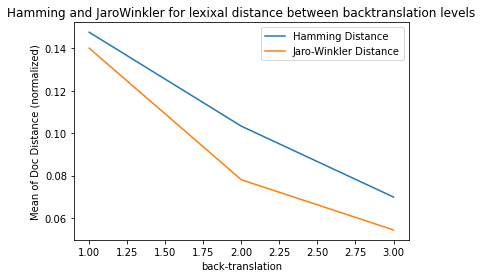

In [ ]:
import matplotlib.pyplot as plt

# line 1 points
x1 = [1,2,3]
y1 = [.147518,.103287,.069894]
# plotting the line 1 points 
plt.plot(x1, y1, label = "Hamming Distance")
# line 2 points
x2 = [1,2,3]
y2 = [.140037,.078046,.054413]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Jaro-Winkler Distance")
plt.xlabel('back-translation')
# Set the y axis label of the current axis.
plt.ylabel('Mean of Doc Distance (normalized)')
# Set a title of the current axes.
plt.title('Hamming and JaroWinkler for lexixal distance between backtranslation levels')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()